# This notebook uses data from Fig. 2b of Goldblatt+2013 to determine T_surf based on OLR (=incoming flux) when below Simpson-Nakajima limit, and allows calculation of P_surf using fully condensible adiabat for pure water vapour atmosphere; above this threshold, planet is in runaway greenhouse, and all water is in atmosphere, setting P_surf, which allows calculation of T_surf.

# ASSUMPTIONS:
## XXXXX NO REGASSING WHEN IN RUNAWAY GREENHOUSE!!!! XXXXX
## XXXXX CONSTANT KAPPA_ABS, TO CALCULATE P_EFF (i.e., level of emitting layer)!!! XXXXX
## XXXXX MINIMUM VALUE OF WATER IN MANTLE SAME AS SURFACE DESICCATION LIMIT, TO AVOID ETA --> INFINITY!!!! XXXXX

## - Luger & Barnes assume 10 Myr formation time; Earth's magma ocean phase ~1.5 Myr; since this is extended around M dwarfs (Lebrun+13), let's assume a magma ocean time of 10 Myr; then, stellar track offset 20 Myr!   XXXXX NOTE, HOWEVER, THAT BARTH+ (2020) ASSUME A DISK LIFETIME OF 5 Myr AT BEGINNING OF MAGMA OCEAN, AND SHOW SOLIDIFICATION TIMESCALES FOR DIFFERENT INITIAL WATER INVENTORIES!!!! XXXXX
## - CONSTANT thermospheric temperature = 400 K (diffusion-limited escape)
## - Pure H2O atmosphere
## - Fully condensible adiabat troposphere & isothermal stratosphere
## Simpson-Nakajima limit on outgoing radiation of 282 W/m^2 (Goldblatt+ 2013)

# THINGS TO TEST:

## - TWO DIFFERENT ALBEDOS (0.3, Earth-like; 0.75, steam atmosphere)
## - TWO DIFFERENT MAGMA OCEAN SOLIDIFICATION TIME OFFSETS -- 20 Myr (or even shorter) & 100 Myr?

######################################################################################################################

# Initialize notebook; import required functions/packages, and read in input parameters/variables from .txt files.

In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import time
import os.path

Populating the interactive namespace from numpy and matplotlib


### XXXX Should probably include new global constants required for 1-D atmosphere/loss calculations in the below cell.

In [2]:
# Need to divide constants into three categories --
# XXXX SEE OTHER RECODED NOTEBOOK FOR DESCRIPTIONS OF ALL CONSTANTS XXXX

# 1) Unchanging constants
# [M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry]

params1 = np.loadtxt('const_params.txt')
M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1

# 2) Varied parameters
# [x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
#  T_serp, K_cnst, gamma, r_fug, d_b]

params2 = np.loadtxt('vary_params.txt')
x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
     T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
# Test different betas; see if the code breaks
#beta = 0.12
#params2[11] = beta

# 3) Changing parameters
# [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]

params3 = np.loadtxt('change_params.txt')
omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
dt_nom = 2.0e4*year
params3[8] = dt_nom

# NEW constants, for 1-D atmosphere calculations
sigma_sb = 5.67e-8 #[W/m^2/K^4]; Stefan-Boltzmann constant
m_H = 1.66e-27 #[kg]; mass of H atom
k_B = 1.38e-23 #[m^2 kg s^-2 K^-1]; Boltzmann constant
m_H2O = 18.02*m_H #molecular mass of water
m_air = 28.7*m_H #molecular mass of air on Earth
rho_water = 997. #[kg/m^3]; density of water
cp_water_vapour = 1.996e3 #[J/(kg K)]; specific heat capacity of water vapour (steam)

## INPUT PARAMETERS: Planet orbital distance and albedo
### XXXX TEST 2 DIFFERENT ALBEDOS TO BRACKET RESULTS XXXX

In [3]:
# Parameters of orbiting planet (can be changed later).
a_orb = 0.06*1.496e11 #[m], roughly middle of HZ around Proxima Cen
alb = 0.3 #albedo; value roughly similar to Earth
#alb = 0.75 #albedo; upper limit to roughly test "steam atmosphere"

# Model Functions/Calculated Constants

In [4]:
## WATER FUGACITY
# Need to calculate non-dimensional water fugacity at each step.
# Formula original from Li et al. (2008), based on experimental data.
def lnf_w(x, params1, params2, params3): #NOTE: Takes non-dimensionalized mantle water mass fraction and converts it.
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

def f_w(x, params1, params2, params3):
    
    return np.exp(lnf_w(x, params1, params2, params3))

In [5]:
## MANTLE VISCOSITY

# Need a function to calculate the viscosity.
def eta(temp, x, params1, params2, params3): #x and T are non-dimensionalized later in code -- need to add dimensions back for these calculations
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    eta_scale = (np.exp(lnf_w(5.8e-4,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
        
    # Need a minimum fugacity, to avoid f_w --> 0 and eta --> infinity.
    # Let's take the 'desiccation limit' for the surface as the minimum value to be 'trapped' in the mantle.
    if x <= 1.29e16/(f_M*M_E):
        return eta_0*(f_w(1.29e16/(f_M*M_E), params1, params2, params3)**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))
    else:
        return eta_0*(f_w(x, params1, params2, params3)**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))
    
    #if f_w(x, params1, params2, params3) > f_w_min:
    #    return eta_0 * (f_w(x, params1, params2, params3)**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))
    #elif f_w(x, params1, params2, params3) <= f_w_min:
    #    return eta_0 * (f_w_min**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))

In [6]:
def Rp(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return R_E*(M/M_E)**0.27

def Rc(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return 0.547*R_E*(M/M_E)**0.25

def h(M):
    return Rp(M) - Rc(M)

def g(M):
    G = 6.67e-11
    return G*M/(Rp(M)**2.)

def A(M):
    return 4.*np.pi*(Rp(M)**2.)

def V(M):
    return (4.*np.pi/3.)*((Rp(M)**3.) - (Rc(M)**3.))

def F_0(M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    f_w = np.exp(lnf_w(5.8e-4,params1,params2,params3))
    return (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta

def L_MOR(M):
    return 1.5*2.*np.pi*Rp(M)

def S(t, temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*\
            (temp-T_surf)/(eta(temp,x,params1,params2,params3)*Ra_c))**(2.*beta))

def tau(M, params1, params2, params3): #useful for converting between different non-dimensional timescales
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (L_MOR(M)*(0.1/year)*x_h*rho_c*chi*d_hE)/(M*omega_0*f_btwid) #spreading rate independent of temp in this model

def Ra(t, temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (alpha*rho_m*g(M)*(temp - T_surf)*(h(M)**3))/(eta(temp, x, params1, params2, params3)*kappa)

# Nusselt number, for looking at heat flux
def Nu(temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (Ra(t, temp, x, T_surf, M, params1, params2, params3)/Ra_c)**beta

# Run MO simulation here.

In [7]:
# Stellar evolution and surface temperature calculations

# Stellar evolution track for 0.13 Msun star (similar to Proxima Cen), from Baraffe+ 2015
# Read in stellar evolution track data
data = np.loadtxt('BHAC15_0.13Msun.txt', skiprows=3)
#data = np.loadtxt('BHAC15_0.3Msun.txt', skiprows=3)
log_age = data[:,1] #log(yr)
T_eff = data[:,2] #[K]
Lbol_Ls = data[:,3] #log luminosity
R_Rs = data[:,5]

Ls = 3.839e33 # [erg/s]; solar bolometric luminosity
Lbol = np.zeros(len(Lbol_Ls))
for idx in range(0,len(Lbol_Ls)):    
    Lbol[idx] = (10.**Lbol_Ls[idx])*Ls/1.0e7 #[W]
    
Rs = 6.96e10 #[cm]; solar radius
Rstar = (R_Rs*Rs)/100.0 #[m]

star_age = np.zeros(len(log_age)) #[s], for later calculations

# Convert stellar age to time, in seconds.
for idx in range(0,len(log_age)):
    star_age[idx] = ((10.0**log_age[idx])*year)
    
print('Stellar age: ', star_age[0]/year, 'years')
#print(star_age[0])
    
# Calculate the top-of-atmosphere bolometric flux, from BHAC15 model.
def S_0(t, M, a_orb, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    t_int = t + (5.0e6*year) #add offset of 5 Myr, to account for formation
    
    return np.interp(t_int, star_age, Lbol)/(4.*np.pi*(a_orb**2.))
    
# Calculate evolution of XUV luminosity (Luger & Barnes 2015; Ribas+ 2005)
def L_XUV(t, M, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    t_int = t + (5.0e6*year) #add offset of 5 Myr, to account for formation
  
    f_sat = 1.0e-3 #saturation fraction
    t_sat = 1.0e9*year #[s], saturation timescale, XXXX SHOULD VARY THIS WHEN TESTING, BASED ON RECENT PAPERS!!! XXXX
    beta_XUV = -1.23
    
    if t <= t_sat:
        return f_sat*np.interp(t_int, star_age, Lbol)
    else: #t > t_sat
        return f_sat*((t_int/t_sat)**beta_XUV)*np.interp(t_int, star_age, Lbol)

# Calculate top-of-atmosphere XUV flux. 
def F_XUV(t, M, a_orb, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
        
    return L_XUV(t, M, params1, params2, params3)/(4.*np.pi*(a_orb**2.))

# Calculate the effective temperature of the planet.
def f_T_eff(t, M, a_orb, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return ((S_0(t, M, a_orb, params1, params2, params3)*(1.0-alb))/(4.0*sigma_sb))**(0.25)

# Calculate the skin temperature (i.e., the isothermal stratosphere temperature). [K]
def T_strat(t, M, a_orb, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return ((1./2.)**0.25)*((S_0(t, M, a_orb, params1, params2, params3)*(1.0-alb))/(4.0*sigma_sb))**(0.25)

Stellar age:  504322.1001372358 years


In [8]:
# Based on Fig. 3 of Barth+2020, Fig. 4 of Schaefer+2016
def d_MO(t, M): 
    
    d_MO_0 = h(M) # ENTIRE MANTLE BEGINS MOLTEN ##2000.0e3 #[m]
    beta_MO = 1./(np.exp(1.)-1)
    
    # TEST MULTIPLE TIMESCALES FOR NOMINAL MODEL -- 10, 50, 100 Myr (50 Myr as nominal)
    tau_MO = 50.0e6*year #conservatively chosen estimate, for mid-HZ, from Barth+2020 Fig. 5
    # XXXXX MO TIMESCALE SHOULD DEPEND ON INITIAL WATER INVENTORY + ORBITAL DISTANCE (~XUV flux)!!!!
    
#    return d_MO_0*np.exp((-t + tau_RG(M, a_orb, alb, params1, params2, params3))/(tau_RG(M, a_orb, alb, params1, params2, params3))) - d_MO_0
#    return (beta_MO*d_MO_0)*np.exp((-t/tau_RG(M, a_orb, alb, params1, params2, params3)) + 1.) - (beta_MO*d_MO_0)
#    return (beta_MO*d_MO_0)*(np.exp((-t/tau_RG(M, a_orb, alb, params1, params2, params3)) + 1.) - 1)
    return (beta_MO*d_MO_0)*(np.exp((-t/tau_MO) + 1.) - 1)

# Temperature of MO as a function of MO depth, using liquidus temperature (Eqn. 1 of Elkins-Tanton 2008)
def T_MO(t, M, a_orb, params1, params2, params3):
    
    r = (Rp(M) - d_MO(t, M))/1000. #[km]
    
    return (-1.16e-7*(r**3.)) + (0.0014*(r**2.)) - (6.382*r) + 1.444e4

def T_sol(r):
    
    return (-1.16e-7*(r**3.)) + (0.0014*(r**2.)) - (6.382*r) + 1.444e4

## Set the initial amount of water in the MO, and calculate the initial concentration.

In [9]:
# Initial mass of water in MO
M_init = 10.*1.4e21 #[kg]

# Initial/constant parameters
D = 0.001 #0.001 OR 0.1 (more water stored in mantle for larger D) #solid-liquid H2O distribution coefficient
R_p = Rp(M_E)/1000. #[km] #6400 km
R_c = Rc(M_E)/1000. #[km] #3000 km
rho = 3.0e3*1.0e9 #[kg/km^3] 
rho_MO = rho #density of MO [kg/km^3] 
#rho_m = rho

# Saturation concentration & initial concentration of water in MO
C_sat = 0.1 #0.1 OR 0.01 (degassing earlier with lower C_sat) #[wt fraction]; H2O saturation limit of MO
#C_0 = 0.005 #[wt fraction]; initial H2O concentration of MO
C_0 = (3.*M_init)/(4.*np.pi*rho*(R_p**3. - R_c**3.))

# Required functions -- RECALL (r = R_p - d_MO(t))
def C_l(r):
    
    return C_0*((R_p**3.-R_c**3.)/(R_p**3.-r**3.))**(1.-D)

def C_s(r):
    
    return D*C_l(r)

def R_sat():
    
    return (R_p**3. - ((R_p**3. - R_c**3.)/((C_sat/C_0)**(1./(1.-D)))))**(1./3.)

def M_MO_unsat(r):
    
    return C_l(r)*(4.*np.pi/3.)*rho_MO*(R_p**3. - r**3.)

def M_SM_unsat(r):
    
    return C_0*(4.*np.pi/3.)*(rho_m*1.0e9)*((R_p**3. - R_c**3.)**(1.-D))*\
            (((R_p**3. - R_c**3.)**D) - ((R_p**3. - r**3.)**D))

def M_MO_sat(r):
    
    return C_sat*(4.*np.pi/3.)*rho_MO*(R_p**3. - r**3.)

def M_SM_sat(r):
    
    return M_SM_unsat(R_sat()) + D*C_sat*(4.*np.pi/3.)*(rho_m*1.0e9)*(r**3.-R_sat()**3.)

In [10]:
print(C_0)

0.005151293448983992


In [11]:
def loss_rate_EL_MO(t, F_XUV, M): #[kg/s]
    
    # R_XUV = XUV deposition radius; LB15 set R_XUV = R_p for simplicity
    # M = planetary mass
    R_p = Rp(M) #[m]
    
    G = 6.67e-11
    eps_XUV = 0.1 #nominal; LB15 test 0.15-0.30
    
    return eps_XUV*np.pi*F_XUV*(R_p**3.)/(G*M)

In [12]:
# Loop to determine whether or not MO is saturated & degas an atmosphere if it is
dt_MO = 2.0e3*year #2000 yr per timestep
t_MO_array = np.arange(0., (50.0e6*year+dt_MO), dt_MO) # 50 Myr; equivalent to MO solidification timescale

M = M_E

# Initial water inventory
#M_init = C_0*(4.*np.pi/3.)*rho*(R_p**3. - R_c**3.) #[kg]; 10 Earth Oceans (where 1 EO = 1.4e21 kg)
M_init = 10.*1.4e21 #[kg]

r_array = R_p - d_MO(t_MO_array, M) #[km]
#r_array = np.arange(3000., 6400., 50.)
M_MO_array = np.zeros(len(r_array))
M_SM_array = np.zeros(len(r_array))
M_atmo_array = np.zeros(len(r_array))
EL_loss_MO_array = np.zeros(len(r_array))
a_orb = 0.06727532*1.496e11 #[m]

# Track MO temperature as a function of r/t.
T_MO_array = np.zeros(len(t_MO_array))

# Keep track of the total water inventory, since it decreases with loss.
M_total = M_init

for idx in range(0,len(r_array)):
    
    EL_loss_MO_array[idx] = loss_rate_EL_MO(t_MO_array[idx], F_XUV(t_MO_array[idx], M, a_orb, params1, params2, params3), M_E)
    T_MO_array[idx] = T_MO(t_MO_array[idx], M, a_orb, params1, params2, params3)

    #MO undersaturated with water, i.e., r <= R_sat
    if r_array[idx] <= R_sat():
        
        M_MO_array[idx] = M_MO_unsat(r_array[idx])
        
        M_SM_array[idx] = M_SM_unsat(r_array[idx])
        
        M_atmo_array[idx] = 0.
        
    # MO saturated/supersaturated with water (r > R_sat); atmosphere forms    
    else: #r_array[idx] > R_sat()
        
        M_MO_array[idx] = M_MO_sat(r_array[idx])
        
        M_SM_array[idx] = M_SM_sat(r_array[idx])
        
        M_atmo_array[idx] = M_total - M_SM_sat(r_array[idx]) - M_MO_sat(r_array[idx])
        
        # Now add loss:
        if M_atmo_array[idx] <= (EL_loss_MO_array[idx]*dt_MO):
            
            M_total = M_total - M_atmo_array[idx]
            M_atmo_array[idx] = 0.
            
        else: #M_atmo_array[idx] > (EL_loss_array[idx]*dt_MO)
            
            M_atmo_array[idx] = M_atmo_array[idx] - (EL_loss_MO_array[idx]*dt_MO)
            M_total = M_total - (EL_loss_MO_array[idx]*dt_MO)

In [13]:
print('R_sat: ', R_sat(), 'km')
for idx in range(0,len(r_array)):
    
    if r_array[idx] > R_sat():
        
        sat_idx = idx
        break
        
print('Saturated at t = ', t_MO_array[sat_idx]/year/1.0e6, 'Myr')
print(sat_idx)
print(len(t_MO_array))

R_sat:  6278.441332447913 km
Saturated at t =  49.998 Myr
24999
25001


In [14]:
print('Initial water = ', M_init/1.4e21, 'Earth Oceans')
print('Final water = ', M_total/1.4e21, 'Earth Oceans')
print('Water lost = ', (M_init - M_total)/1.4e21, 'Earth Oceans')

Initial water =  10.0 Earth Oceans
Final water =  9.999968323366199 Earth Oceans
Water lost =  3.1676633800469945e-05 Earth Oceans


In [15]:
print('Max possible water lost, once atmosphere forms: ', (np.sum(EL_loss_MO_array[sat_idx:])*dt_MO)/1.4e21, 'Earth Oceans')
print('Max possible water lost, if EL the entire time: ', (np.sum(EL_loss_MO_array)*dt_MO)/1.4e21, 'Earth Oceans')

Max possible water lost, once atmosphere forms:  3.1676633800371255e-05 Earth Oceans
Max possible water lost, if EL the entire time:  0.7591310691813022 Earth Oceans


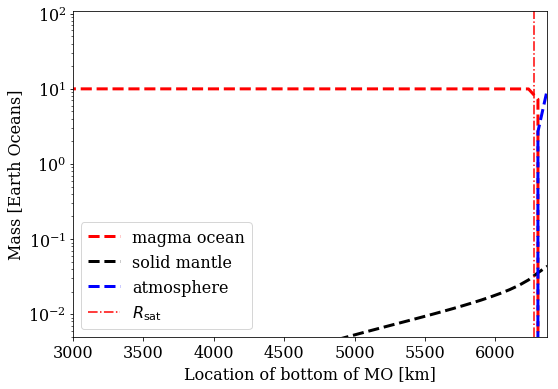

In [16]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.semilogy(r_array, M_MO_array/1.4e21, color='r', linestyle='--', linewidth=3, label='magma ocean')
plt.semilogy(r_array, M_SM_array/1.4e21, color='k', linestyle='--', linewidth=3, label='solid mantle')
plt.semilogy(r_array, M_atmo_array/1.4e21, color='b', linestyle='--', linewidth=3, label='atmosphere')
plt.axvline(x=R_sat(), color='r', linestyle='-.', label=r'$R_\mathrm{{sat}}$')
plt.xlabel('Location of bottom of MO [km]', fontsize=16)
plt.ylabel('Mass [Earth Oceans]', fontsize=16)
plt.xlim(3000., Rp(M)/1000.)
plt.ylim(0.005, 110.)
plt.legend(loc='lower left', fontsize=16)

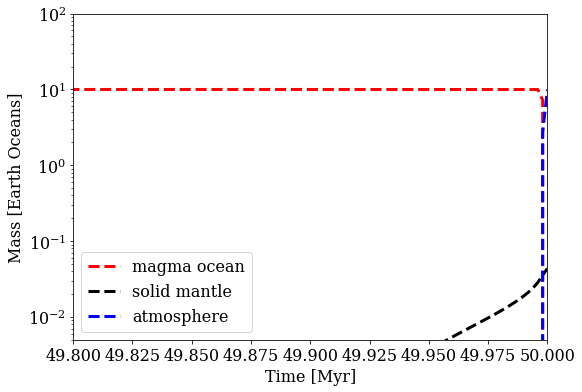

In [17]:
# Can also be plotted as a function of time.
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.semilogy(t_MO_array/year/1.0e6, M_MO_array/1.4e21, color='r', linestyle='--', linewidth=3, label='magma ocean')
plt.semilogy(t_MO_array/year/1.0e6, M_SM_array/1.4e21, color='k', linestyle='--', linewidth=3, label='solid mantle')
plt.semilogy(t_MO_array/year/1.0e6, M_atmo_array/1.4e21, color='b', linestyle='--', linewidth=3, label='atmosphere')
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Mass [Earth Oceans]', fontsize=16)
plt.xlim([49.8, 50.])
plt.ylim(0.005, 100.)
plt.legend(loc='lower left', fontsize=16)

### The functions in the following cell have been added since the first model iteration.

In [18]:
# Seafloor pressure
def P(s, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return M*g(M)*s/(f_b*4*np.pi*(Rp(M)**2))

# T-dependent hydration depth
def d_h(t, temp, T_surf, x, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (h(M)**(1.0-3.0*beta))*((temp-T_surf)**(-(1.0+beta)))*\
        (T_serp-T_surf)*((eta(temp,x,params1,params2,params3)*kappa*Ra_c/(alpha*rho_m*g(M)))**beta)

# Radionuclide heating, using 4 common Earth mantle species (i.e., nominal bulk silicate Earth, 21 ppb U)
# (Schaefer & Sasselov 2015, Eqn. (4), with constants as given in Laura's MATLAB code (see refs there))
def Q_sum(t, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    # Mantle concentration of element by mass (Schubert et al. 2001, Ch. 4)
    Uran = 21e-9; #[U] = 21 ppb
    C_238U = 0.9927 * Uran;
    C_235U = 0.0072 * Uran;
    C_40K = 1.28 * Uran;
    C_232Th = 4.01 * Uran;
    
    # Heat production per unit mass (Schubert et al. 2001, Ch. 4)
    H_238U = 9.37e-5;
    H_235U = 5.69e-4;
    H_232Th = 2.69e-5;
    H_40K = 2.79e-5;
    
    # Decay constants
    lam_238U = 0.155e-9;
    lam_235U = 0.985e-9;
    lam_232Th = 0.0495e-9;
    lam_40K = 0.555e-9;
    
    return rho_m*(C_238U*H_238U*np.exp(lam_238U*(4.6e9-t)) + C_235U*H_235U*np.exp(lam_235U*(4.6e9-t)) + \
            C_232Th*H_232Th*np.exp(lam_232Th*(4.6e9-t)) + C_40K*H_40K*np.exp(lam_40K*(4.6e9-t)))

In [19]:
# Things that need to be calculated with constants and above functions:
# NOTE: If dimensions are being used anyway, many of these are redundant/won't be used in the code.
omg_Etwid = num_oceans*omega_E/omega_0
omegatwid = omg_Etwid/(f_btwid)
T_stwid = T_s/T_ref
T_mtwid = T_ref*R_g/E_a
T_liqtwid = T_liq_dry/T_ref
T_soltwid = T_sol_dry/T_ref
Ktwid = K_cnst/T_ref
Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
eta_scale = (np.exp(lnf_w(5.8e-4,params1,params2,params3)))**(-r_fug)
eta_0 = 1.0e21/eta_scale
#f_w = np.exp(lnf_w(1.,params1,params2,params3))
f_wtwid_min = 1.0e-5 #CONSERVATIVELY CHOSEN FOR NOW
E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
#tau_heat = Q_0/(rho_m*c_p*T_ref)

# 4) Calculated parameters
params4 = [omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E]

# 1-D Atmosphere & Loss Functions

In [20]:
# Other variables/functions, required for the adiabats and water saturation pressure.

P_0_star = 1.4e11 #[Pa]
l_c_NJ = 43655 #[J/mol] THIS VALUE IS USED BY NAKAJIMA+ 1992
l_c = 2441.7e3 # [J/kg] (https://www.engineeringtoolbox.com/water-properties-d_1573.html)
R_gas_NJ = 8.314 #[J/mol/K] THIS VALUE IS USED BY NAKAJIMA+ 1992
R_gas = 8314. #[J/kg/K]

# Saturation water vapour pressure
def P_star(T): 
    
    return P_0_star*np.exp(-l_c_NJ/(R_gas_NJ*T))

# Specific heat -- Nakajima+ (1992) uses these values
c_pv_NJ = 4*R_gas #specific heat at constant P of condensable
c_pn_NJ = 3.5*R_gas #specific heat at constant P of non-condensable
#c_pn = 4.5*R_gas # this value is also tested by Nakajima+ 1992

# ALTERNATIVELY, use known measured values for these specific heats 
#(https://www.engineeringtoolbox.com/specific-heat-capacity-d_391.html)
c_pn = 1005 #[J/(kg K)] specific heat of dry air at constant P
c_pv = 1864 #[J/(kg K)] specific heat of water vapour at constant P (& at 300 K)

In [21]:
# Use Goldblatt provided data, to reproduce Fig. 2b of Goldblatt+2013, for the Earth.
data = np.loadtxt('Goldblatt_Tsurf_OLR.txt')
T_surf_gb = data[:,0] # [K]
OLR_gb = data[:,1] #[K] 

#plt.plot(T_surf_gb, OLR_gb)

def T_surf_OLR(t, M, alb, a_orb, params1, params2, params3):
    
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)): #runaway greenhouse
                
        return 1800. #~maximum T_surf corresponding to given OLR
    
    else: #not in runaway greenhouse
        
        # Set OLR = absorbed flux
        OLR = (S_0(t, M, a_orb, params1, params2, params3)/4.)*(1.-alb)
        
        # Do a very simple linear extrapolation FOR NOW.
        z = np.polyfit(T_surf_gb[0:4], OLR_gb[0:4], 1)

        if OLR <= np.min(OLR_gb): #arbitrary lower limit
            
            return np.min(T_surf_gb) + ((OLR - np.min(OLR_gb))/z[0])
        
        else:
            
            return np.interp(OLR, OLR_gb, T_surf_gb)

In [22]:
# Find the mass absorption coefficient for Earth's atmosphere.
T_eff_E = 252. #[K]
T_surf_E = 288. #[K]
P_surf_E = 1.0e5 #[Pa]
H_E = 8.5 #[km]
g_E = g(M_E)
gamma_trop = 6.5 #[K/km]

z_eff_E = (T_surf_E - T_eff_E)/gamma_trop #[km]

kappa_E = g_E/(P_surf_E*np.exp(-z_eff_E/H_E))
print(kappa_E)

# Use this kappa to find total optical depth of Earth's atmosphere.
tau_0 = (P_surf_E/g_E)*kappa_E
print(tau_0)

# Pressure of emitting level, where tau = 1 or 2/3 (latter accounts for slant geometry).
# XXXX SHOULD CHANGE THE BELOW FUNCTION IF ACTUALLY SOLVING FOR A P_EFF, IF Z_EFF KNOWN!
#def f_P_eff(t, T, P_surf, z_eff, M, m): 
def f_P_eff(t, M): 
    
    # Value for absorption in 6.5-6.67 µm band (BUT WILL HAVE TO CHANGE THIS LATER BASED ON T_EFF)
    # (https://bartonlevenson.com/ConvertingAbsorptionCoefficients.html)
    #kappa = 25. #[m^2/kg]
    #kappa = 0.86 #[m^2/kg] #absorption window, 12-25 µm band
    #kappa_abs_ref = 0.01 #[m^2/kg], at reference pressure P = 101325 Pa (Yamamoto & Onishi, 1952)
    
    # These two variables go hand-in-hand.
    kappa_0 = 0.055 # Pierrehumbert, pg. 282
    P_0 = 1.0e4 # Pierrehumbert, pg. 282
    
    # A roughly square-root dependence, based on Fig. 5 of Yamamoto & Onishi (1952). XXXX NOT USED XXXX
    #kappa_abs = kappa_abs_ref*((P_surf/1.0e5)**0.5)

    tau = 1.
    #tau = 2./3.
    
    #return tau*g(M)/kappa_abs_ref
    return (2.*P_0*g(M)/kappa_0)**0.5

0.00018828235976533795
1.9185768944499397


In [23]:
# Function to determine total mass of water in atmosphere, given T_surf, surface water inventory, albedo.
def f_M_H2O(t, W_s, T_surf, alb, M, m, a_orb, params1, params2, params3):
    
    # Runaway greenhouse limit; divide by 4 because planet is a sphere
    # All surface water in atmosphere
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)):
        
        return W_s #[kg]
        
    else:
        
        return (P_star(T_surf)/g(M))*4.*np.pi*(Rp(M)**2.) #[kg]
    
def f_P_surf(t, W_s, T_surf, alb, M, m, a_orb, params1, params2, params3):
    
    # Runaway greenhouse limit; divide by 4 because planet is a sphere
    # All surface water in atmosphere
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)):
        
        return W_s*g(M)/(4.*np.pi*(Rp(M)**2.))
    
    else:
        
        return P_star(T_surf)

### Energy-limited & diffusion-limited loss, from Luger & Barnes (2015)

In [24]:
# Energy-limited escape rate
def loss_rate_EL(t, F_XUV, R_XUV, M): #[kg/s]
    
    # R_XUV = XUV deposition radius; LB15 set R_XUV = R_p for simplicity
    # M = planetary mass
    
    G = 6.67e-11
    eps_XUV = 0.1 #nominal; LB15 test 0.15-0.30
    
    return eps_XUV*np.pi*F_XUV*Rp(M)*(R_XUV**2.)/(G*M)

# Diffusion-limited escape rate
def loss_rate_DL(t, T_surf, T_strat, M):
    
    g_p = g(M)*100. #[cm s^-2], to match the units of b
    k_B = 1.38e-23 #[m^2 kg s^-2 K^-1]; Boltzmann constant
    
    # Mole fractions of H & O (assuming all H2O is dissociated)
    X_H = 2./3.
    X_O = 1./3.
    
    m_H = 1.66e-27 #[kg]; mass of H atom
    m_O = 16.*m_H
    
    #if T_surf < 647.:
        
        #b = 4.8e17*(T_strat**0.75) #[cm^-1 s^-1]

        #return m_H*(np.pi*(Rp(M)**2.)*b*g_p*(m_O-m_H))/(k_B*T_strat*(1.+(X_O/X_H)))
    
    #else: #T_surf >= 647.; take average thermospheric temperature of 400 K in runaway GH
        
    # Just take the thermospheric temperature as 400 K at all times, for now.
    b = 4.8e17*(400.**0.75) #[cm^-1 s^-1]
        
    return m_H*(np.pi*(Rp(M)**2.)*b*g_p*(m_O-m_H))/(k_B*400.*(1.+(X_O/X_H))) 

# Cycling Functions

In [25]:
# Thermal evolution

def f_delta_temp(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    s = W_s/M
    
#    return (1./(rho_m*c_p))*((Q_0*np.exp(-t/2.0e9)) - \
#        (k*A(M)*(temp-T_s)/(h(M)*V(M)))*(Ra(temp, x, M, params1, params2, params3)/Ra_c)**beta)

    return (1./(rho_m*c_p))*((Q_sum(t, M, params1, params2, params3)) - \
        (k*A(M)*(temp-T_surf)/(h(M)*V(M)))*(Ra(t, temp, x, T_surf, M, params1, params2, params3)/Ra_c)**beta)

# Degassing (using 1% melt approximation of Komaceck & Abbot 2016)

def f_degas(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    s = W_s/M
    
    # Mantle temperature check
    if temp > T_sol_dry-K_cnst*x**gamma: 
    
        # Piecewise limit from CA2014
        if x > 0. and s > 0. and f_degasE*(P(s, M, params1, params2, params3)/P_E)**(-mu) < 1.:
            return L_MOR(M)*S(t, temp, x, T_surf, M, params1, params2, params3)*(x*rho_m*d_melt*\
                (f_degasE*(P(s, M, params1, params2, params3)/P_E)**(-mu))*\
                ((temp-(T_sol_dry-K_cnst*x**gamma))/(T_liq_dry-T_sol_dry))**theta)
    
        elif x > 0. and s > 0. and f_degasE*(P(s, M, params1, params2, params3)/P_E)**(-mu) >= 1.:
            return L_MOR(M)*S(t, temp, x, T_surf, M, params1, params2, params3)*(x*rho_m*d_melt*\
                (1.)*((temp-(T_sol_dry-K_cnst*x**gamma))/(T_liq_dry-T_sol_dry))**theta)
    
        elif x > 0. and s <= 0.:
            return L_MOR(M)*S(t, temp, x, T_surf, M, params1, params2, params3)*(x*rho_m*d_melt*\
                (1.)*((temp-(T_sol_dry-K_cnst*x**gamma))/(T_liq_dry-T_sol_dry))**theta)
    
        else: # x <= 0.; no degassing
            return 0.
        
    else: # temp <= T_sol_dry-K_cnst*x**gamma; no degassing
        return 0.
    
# Regassing (adding regassing check of CA14 to T-dependent regassing of SS15)

def f_regas(t, temp, W_m, W_s, T_surf, alb, M, a_orb, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    s = W_s/M
    
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)):
        
        # Runaway greenhouse; all water in atmosphere so NO regassing!!!
        return 0.
        
    else:
    
        # Piecewise limit from CA2014
        if x > 0. and s > 0. and d_h(t, temp, T_surf, x, M, params1, params2, params3)*(P(s, M, params1, params2, params3)/P_E)**sigma < d_b:
            return L_MOR(M)*S(t, temp, x, T_surf, M, params1, params2, params3)*(x_h*rho_c*chi_r*\
                d_h(t, temp, T_surf, x, M, params1, params2, params3)*(P(s, M, params1, params2, params3)/P_E)**sigma)
    
        elif x > 0. and s > 0. and d_h(t, temp, T_surf, x, M, params1, params2, params3)*(P(s, M, params1, params2, params3)/P_E)**sigma >= d_b:
            return L_MOR(M)*S(t, temp, x, T_surf, M, params1, params2, params3)*(x_h*rho_c*chi_r*d_b)
    
        elif x <= 0. and s > 0.: # not a big fan of this condition choice (constant spreading rate)
            return L_MOR(M)*(0.1/year)*(x_h*rho_c*chi_r*d_b)
    
        elif s <= 0.: # no regassing
            return 0.
    
# Water loss; ENERGY-LIMITED OR DIFFUSION-LIMITED ESCAPE (Luger & Barnes 2015)

def f_loss(t, temp, W_m, W_s, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    s = W_s/M
    
    # Runaway greenhouse limit; divide by 4 because planet is a sphere
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)):
        
        # Energy-limited loss; set R_XUV = R_p, for simplicity
        M_loss = loss_rate_EL(t, F_XUV(t, M, a_orb, params1, params2, params3), Rp(M), M) #[kg/s]
        
    else:
           
        # Take the lower value of EL and DL loss rates. 
        M_loss = np.minimum(loss_rate_EL(t, F_XUV(t, M, a_orb, params1, params2, params3), Rp(M), M), \
                        loss_rate_DL(t, T_surf, T_strat, M)) #[kg/s]
        
    # XXXX For our purposes, replenishment time above exobase is ~instantaneous; therefore, we can take water directly
    # from the surface reservoir, for now.
    # Piecewise def'n from me, so you don't lose more than on the surface
    if M_loss < W_s/dt:
        return M_loss
    else:
        return W_s/dt
    
    #return 0. #no loss

In [26]:
# Change in mantle water with time

def f_delta_W_m(t, temp, W_m, W_s, T_surf, alb, dt, M, a_orb, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    s = W_s/M
    
    d_W_m = f_regas(t, temp, W_m, W_s, T_surf, alb, M, a_orb, params1, params2, params3, params4) - \
            f_degas(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4)
    
    # Mantle water capacity check
    if W_m + (d_W_m*dt) <= 12.0*1.4e21:
        return d_W_m
    else:
        return ((12.0*1.4e21) - W_m)/dt

# Change in surface water with time

def f_delta_W_s(t, temp, W_m, W_s, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    s = W_s/M
    
    d_W_m = f_regas(t, temp, W_m, W_s, T_surf, alb, M, a_orb, params1, params2, params3, params4) - \
            f_degas(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4)
    
    # Mantle water capacity check
    if W_m + (d_W_m*dt) <= 12.0*1.4e21:
        return f_degas(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4) - \
            f_regas(t, temp, W_m, W_s, T_surf, alb, M, a_orb, params1, params2, params3, params4) - \
            f_loss(t, temp, W_m, W_s, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4)
    else:
        return -(((12.0*1.4e21) - W_m)/dt) - \
            f_regas(t, temp, W_m, W_s, T_surf, alb, M, a_orb, params1, params2, params3, params4) - \
            f_loss(t, temp, W_m, W_s, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4)

# Cycling equation, to be integrated

def f_cycling(t, z, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp = z[0]
    W_m = z[1]
    W_s = z[2]
    
    return [f_delta_temp(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4),\
                f_delta_W_m(t, temp, W_m, W_s, T_surf, alb, dt, M, a_orb, params1, params2, params3, params4),\
                f_delta_W_s(t, temp, W_m, W_s, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4)]

# Time-dependent Cycling & Loss Simulations

In [27]:
# input parameters
# Need various values of initial water inventories -- USE OUTPUT FROM ABOVE MO MODEL RUNS.
W_m_init = M_SM_array[-1] #[kg]
W_s_init = M_atmo_array[-1] #[kg]

In [28]:
# Set initial conditions.
t0 = 50.0e6*year #0
W_total = 2.*1.4e21 #10.*1.4e21
#z0 = [3000., W_total/2., W_total/2.] #partioned equally between surface & mantle
#z0 = [3000., 0.1*W_total, 0.9*W_total] #rough partitioning at end of magma ocean, for GJ 1132b (Schaefer+16)
#z0 = [3000., 0.5*W_total, 4.5*W_total] #rough partioning at end of MO, for TRAPPIST-1 planets (Barth+20)
z0 = [3000., W_m_init, W_s_init] #[K] [kg] [kg]
M = M_E
# Atmosphere initial conditions.
m = m_H2O #molecular mass of water 
a_orb = 0.06727532*1.496e11 #[m], middle of HZ around Proxima Cen (calculated from Kopparapu+2013)
alb = 0.3 #0.1 #albedo
T_surf_0 = T_surf_OLR(t0, M, alb, a_orb, params1, params2, params3)
P_surf_0 = f_P_surf(t0, z0[2], T_surf_0, alb, M, m, a_orb, params1, params2, params3)
T_strat_0 = T_strat(t0, M, a_orb, params1, params2, params3)
# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 5.0e9*year #5 Gyr
dt = 2.0e4*year #20,000 yr per timestep

count_array = np.zeros(int((t1-t0)/dt)+1) #IF LIMITED BY AMOUNT OF WATER, SET = 1; OTHERWISE, LEAVE AS 0

# Set up function to be integrated.
r = ode(f_cycling).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(T_surf_0,T_strat_0,alb,dt,M,a_orb,params1,params2,params3,params4)

# Define arrays to be filled within the integration loop.
###t_array = np.zeros(int(t1/dt)+1)
t_array = np.zeros(int((t1-t0)/dt)+1)
# Cycling
T_array = np.zeros(int((t1-t0)/dt)+1)
W_m_array = np.zeros(int((t1-t0)/dt)+1)
W_s_array = np.zeros(int((t1-t0)/dt)+1)
regas_array = np.zeros(int((t1-t0)/dt)+1)
degas_array = np.zeros(int((t1-t0)/dt)+1)
# Atmosphere
T_surf_array = np.zeros(int((t1-t0)/dt)+1)
T_strat_array = np.zeros(int((t1-t0)/dt)+1)
TOA_flux_array = np.zeros(int((t1-t0)/dt)+1)
loss_array = np.zeros(int((t1-t0)/dt)+1)
EL_array = np.zeros(int((t1-t0)/dt)+1)
DL_array = np.zeros(int((t1-t0)/dt)+1)
M_H2O_array = np.zeros(int((t1-t0)/dt)+1)
P_eff_array = np.zeros(int((t1-t0)/dt)+1)
P_surf_array = np.zeros(int((t1-t0)/dt)+1)

# Initial values in the arrays.
t_array[0] = t0
# Cycling
T_array[0] = z0[0]
W_m_array[0] = z0[1]
W_s_array[0] = z0[2]
regas_array[0] = f_regas(t0, z0[0], z0[1], z0[2], T_surf_0, alb, M, a_orb, params1, params2, params3, params4)
degas_array[0] = f_degas(t0, z0[0], z0[1], z0[2], T_surf_0, M, params1, params2, params3, params4)
# Atmosphere
T_surf_array[0] = T_surf_0
T_strat_array[0] = T_strat_0
TOA_flux_array[0] = S_0(t0, M, a_orb, params1, params2, params3)
loss_array[0] = f_loss(t0, z0[0], z0[1], z0[2], T_surf_0, T_strat_0, alb, dt, M, a_orb, params1, params2, params3, params4)
EL_array[0] = loss_rate_EL(t0, F_XUV(t0, M, a_orb, params1, params2, params3), Rp(M), M) #[kg/s]
DL_array[0] = loss_rate_DL(t0, T_surf_0, T_strat_0, M) #[kg/s]
M_H2O_array[0] = f_M_H2O(t0, z0[2], T_surf_0, alb, M, m, a_orb, params1, params2, params3)
P_eff_array[0] = f_P_eff(t0, M)
P_surf_array[0] = P_surf_0

# Integrate the above function.
idx = 1
start_time = time.time()
for idx in range(1,len(t_array)):
    
    if r.successful() == True:
        r.integrate(r.t+dt)
        t_array[idx] = r.t
        T_array[idx] = r.y[0]
        W_m_array[idx] = r.y[1]
        W_s_array[idx] = r.y[2]
        
        ########
         # Runaway greenhouse limit; divide by 4 because planet is a sphere
        if S_0(r.t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)):
        
            # Energy-limited loss; set R_XUV = R_p, for simplicity
            M_loss = loss_rate_EL(r.t, F_XUV(r.t, M, a_orb, params1, params2, params3), Rp(M), M) #[kg/s]
        
        else:
           
            # Take the lower value of EL and DL loss rates. 
            M_loss = np.minimum(loss_rate_EL(r.t, F_XUV(r.t, M, a_orb, params1, params2, params3), Rp(M), M), \
                            loss_rate_DL(r.t, T_surf_array[idx], T_strat_array[idx], M)) #[kg/s]
        
        # Piecewise def'n from me, so you don't lose more than on the surface
        if M_loss*dt > W_s_array[idx]:
            count_array[idx] = 1
        ########
        
        T_surf_array[idx] = T_surf_OLR(r.t, M, alb, a_orb, params1, params2, params3)
        P_surf_array[idx] = f_P_surf(r.t, r.y[2], T_surf_array[idx], alb, M, m, a_orb, params1, params2, params3)
        T_strat_array[idx] = T_strat(r.t, M, a_orb, params1, params2, params3)
        TOA_flux_array[idx] = S_0(r.t, M, a_orb, params1, params2, params3)
        
        regas_array[idx] = f_regas(r.t, r.y[0], r.y[1], r.y[2], T_surf_array[idx], alb, M, a_orb, params1, params2, params3, params4)
        degas_array[idx] = f_degas(r.t, r.y[0], r.y[1], r.y[2], T_surf_array[idx], M, params1, params2, params3, params4)
        loss_array[idx] = f_loss(r.t, r.y[0], r.y[1], r.y[2], T_surf_array[idx], T_strat_array[idx], alb, dt, M, a_orb, params1, params2, params3, params4)
        EL_array[idx] = loss_rate_EL(r.t, F_XUV(r.t, M, a_orb, params1, params2, params3), Rp(M), M) #[kg/s]
        DL_array[idx] = loss_rate_DL(r.t, T_surf_array[idx], T_strat_array[idx], M) #[kg/s]
        M_H2O_array[idx] =  f_M_H2O(r.t, r.y[2], T_surf_array[idx], alb, M, m, a_orb, params1, params2, params3)
        P_eff_array[idx] = f_P_eff(r.t, M)
        
    elif r.successful() == False:
        M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
        x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
            T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
        omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
        omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
            eta_scale, eta_0, f_w, f_wtwid_min, E = params4
       
        t_array[idx] = t_array[idx-1] + dt
        T_array[idx] = T_array[idx-1] + \
            f_delta_temp(t_array[idx-1], T_array[idx-1], W_m_array[idx-1], W_s_array[idx-1], T_surf_array[idx-1], M, params1, params2, params3, params4)*dt
        W_m_array[idx] = W_m_array[idx-1] + \
            f_delta_W_m(t_array[idx-1], T_array[idx-1], W_m_array[idx-1], W_s_array[idx-1], T_surf_array[idx-1], alb, dt, M, a_orb, params1, params2, params3, params4)*dt
        W_s_array[idx] = W_s_array[idx-1] + \
            f_delta_W_s(t_array[idx-1], T_array[idx-1], W_m_array[idx-1], W_s_array[idx-1], T_surf_array[idx-1], T_strat_array[idx-1], alb, dt, M, a_orb, params1, params2, params3, params4)*dt

        ########
        # Runaway greenhouse limit; divide by 4 because planet is a sphere
        if S_0(t_array[idx], M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)):
        
            # Energy-limited loss; set R_XUV = R_p, for simplicity
            M_loss = loss_rate_EL(t_array[idx], F_XUV(t_array[idx], M, a_orb, params1, params2, params3), Rp(M), M) #[kg/s]
        
        else:
           
            # Take the lower value of EL and DL loss rates. 
            M_loss = np.minimum(loss_rate_EL(t_array[idx], F_XUV(t_array[idx], M, a_orb, params1, params2, params3), Rp(M), M), \
                            loss_rate_DL(t_array[idx], T_surf_array[idx], T_strat_array[idx], M)) #[kg/s]
        
        # Piecewise def'n from me, so you don't lose more than on the surface
        if M_loss*dt > W_s_array[idx]:
            count_array[idx] = 1
        ########
                
        T_surf_array[idx] = T_surf_OLR(t_array[idx], M, alb, a_orb, params1, params2, params3)
        P_surf_array[idx] = f_P_surf(t_array[idx], W_s_array[idx], T_surf_array[idx], alb, M, m, a_orb, params1, params2, params3)
        T_strat_array[idx] = T_strat(t_array[idx], M, a_orb, params1, params2, params3)
        TOA_flux_array[idx] = S_0(t_array[idx], M, a_orb, params1, params2, params3)
        
        regas_array[idx] = f_regas(t_array[idx], T_array[idx-1], W_m_array[idx], W_s_array[idx], T_surf_array[idx], alb, M, a_orb, params1, params2, params3, params4)
        degas_array[idx] = f_degas(t_array[idx], T_array[idx-1], W_m_array[idx], W_s_array[idx], T_surf_array[idx], M, params1, params2, params3, params4)
        loss_array[idx] = f_loss(t_array[idx], T_array[idx-1], W_m_array[idx], W_s_array[idx], T_surf_array[idx], T_strat_array[idx], alb, dt, M, a_orb, params1, params2, params3, params4)
        EL_array[idx] = loss_rate_EL(t_array[idx], F_XUV(t_array[idx], M, a_orb, params1, params2, params3), Rp(M), M) #[kg/s]
        DL_array[idx] = loss_rate_DL(t_array[idx], T_surf_array[idx], T_strat_array[idx], M) #[kg/s]
        M_H2O_array[idx] =  f_M_H2O(t_array[idx], W_s_array[idx], T_surf_array[idx], alb, M, m, a_orb, params1, params2, params3)
        P_eff_array[idx] = f_P_eff(t_array[idx], M)

        # Leave the loop if both reservoirs have zero water.
        # XXXX ALTERNATIVE DESICCATION LIMIT: 10^-5 TO (SLIGHTLY LESS ACCURATE THOUGH) XXXX
        #if W_m_array[idx] <= 1.29e16 and W_s_array[idx] <= 1.29e16:
        if W_m_array[idx]+W_s_array[idx] <= 1.29e16:
            print('Planet Desiccated')
            break
        
    #idx = idx + 1
    
end_time = time.time()
print(end_time-start_time, ' s')
print('Escape limited by surface water: ', np.sum(count_array), 'of ', (int(t1/dt)+1), 'runs.')

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


274.14385890960693  s
Escape limited by surface water:  0.0 of  250001 runs.


In [29]:
## DEBUGGING
#print(t_array[idx], t_array[idx-1])
#print(T_array[idx], T_array[idx-1])
#print(W_m_array[idx], W_m_array[idx-1])
#print(W_s_array[idx], W_s_array[idx-1])
#print(regas_array[idx], regas_array[idx-1])
#print(degas_array[idx], degas_array[idx-1])
#print(T_surf_array[idx], T_surf_array[idx-1])
#print(T_strat_array[idx], T_strat_array[idx-1])
#print(TOA_flux_array[idx], TOA_flux_array[idx-1])
#print(loss_array[idx], loss_array[idx-1])
#print(EL_array[idx], EL_array[idx-1])
#print(DL_array[idx], DL_array[idx-1])
#print(M_H2O_array[idx], M_H2O_array[idx-1])
#print(P_eff_array[idx], P_eff_array[idx-1])
#print(P_surf_array[idx], P_surf_array[idx-1])
#print(t_array[idx]/year/1.0e9)

# Plot the simulation results.

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


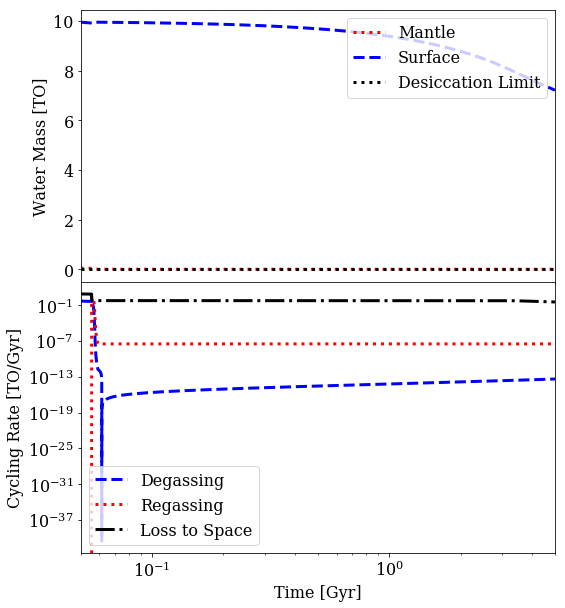

In [30]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(2,1,1)
#plt.loglog(t_array/year/1.0e9, W_m_array/1.4e21, linewidth=3, color='r', linestyle=':', label='Mantle')
#plt.loglog(t_array/year/1.0e9, W_s_array/1.4e21, linewidth=3, color='b', linestyle='--', label='Surface')
plt.semilogx(t_array[0:idx-1]/year/1.0e9, W_m_array[0:idx-1]/1.4e21, linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array[0:idx-1]/year/1.0e9, W_s_array[0:idx-1]/1.4e21, linewidth=3, color='b', linestyle='--', label='Surface')
plt.axhline(y=1.29e16/1.4e21, color='k', linestyle=':',linewidth=3, label='Desiccation Limit')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.05, 5.0])
plt.ylabel(r'Water Mass [TO]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(2,1,2)
plt.loglog(t_array[0:idx-1]/year/1.0e9, degas_array[0:idx-1]/1.4e21*year*1.0e9, linewidth=3, color='b', linestyle='--', label='Degassing')
plt.loglog(t_array[0:idx-1]/year/1.0e9, regas_array[0:idx-1]/1.4e21*year*1.0e9, linewidth=3, color='r', linestyle=':', label='Regassing')
plt.loglog(t_array[0:idx-1]/year/1.0e9, loss_array[0:idx-1]/1.4e21*year*1.0e9, linewidth=3, color='k', linestyle='-.', label='Loss to Space')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.05, 5.0])
plt.ylabel(r'Cycling Rate [TO/Gyr]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
#plt.ylim([-0.05,650.])
#plt.legend(bbox_to_anchor=(0.0, 1.0), ncol=2, fontsize=16)

#plt.savefig('Cycling_Loss_1DAtmos_1TO_loglog.pdf', bbox_inches='tight')
#plt.savefig('Cycling_Loss_1DAtmos_1TO_loglog_Psurf_0d01bar.pdf', bbox_inches='tight')
#plt.savefig('Cycling_Loss_1DAtmos_1TO_loglog_Psurf_270bar.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


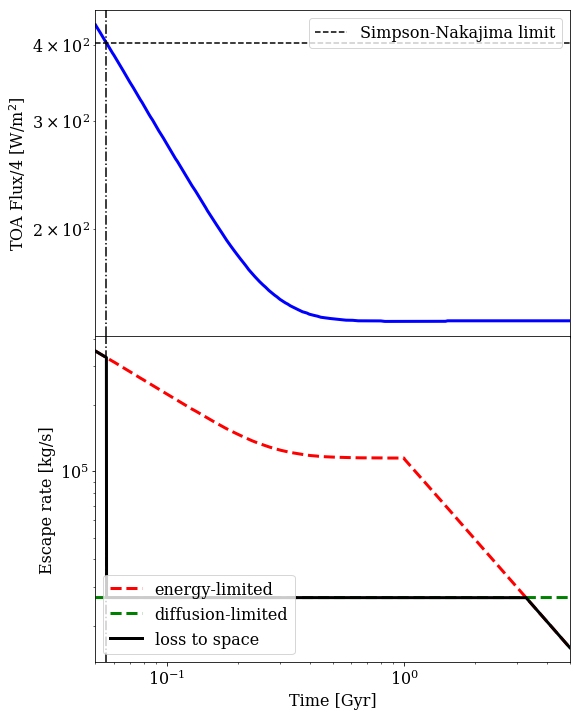

In [31]:
# Plot TOA flux over time, and a horizontal line with Goldblatt/Watson limit of 300 W/m^2.
# First, find where runaway greenhouse ends, to be plotted as a vertical line.
for idx in range(0, len(t_array)):
    
    if TOA_flux_array[idx]/4. < 282./(1.-alb):
        
        exit_time = t_array[idx]
        exit_idx = idx
        break

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,12))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(2, 1, 1)
plt.loglog(t_array/year/1.0e9, TOA_flux_array/4, linewidth=3, color='b') #divide by 4 for sphere
plt.axhline(282./(1.-alb), color='k', linestyle='--', label='Simpson-Nakajima limit')
plt.axvline(exit_time/year/1.0e9, color='k', linestyle='-.')
#plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.05, 5.0])
plt.ylabel(r'TOA Flux/4 [W/m$^2$]', fontsize=16)
plt.legend(fontsize=16, loc='upper right')

ax2 = plt.subplot(2, 1, 2)
plt.loglog(t_array/year/1.0e9, EL_array, linewidth=3, color='r', linestyle='--', label='energy-limited')
plt.loglog(t_array/year/1.0e9, DL_array, linewidth=3, color='g', linestyle='--', label='diffusion-limited')
plt.axvline(exit_time/year/1.0e9, color='k', linestyle='-.')
#Plot in bold the actual loss prescription being followed, based on TOA flux runaway greenhouse limit.
plt.loglog(t_array/year/1.0e9, loss_array, linewidth=3, color='k', label='loss to space')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.05, 5.0])
plt.ylabel('Escape rate [kg/s]', fontsize=16)
plt.legend(fontsize=16, loc='lower left')

#plt.savefig('Cycling_Loss_1DAtmos_1TO_TOAFlux_LossRates_loglog.pdf', bbox_inches='tight')
#plt.savefig('Cycling_Loss_1DAtmos_1TO_TOAFlux_LossRates_loglog_Psurf_0d01bar.pdf', bbox_inches='tight')
#plt.savefig('Cycling_Loss_1DAtmos_1TO_TOAFlux_LossRates_loglog_Psurf_270bar.pdf', bbox_inches='tight')

Minimum surface temperature =  207.7448813263947 K


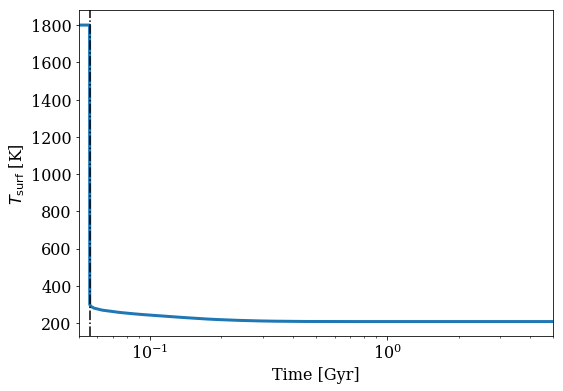

In [32]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()
ax = [fig.add_subplot(1,1,i+1) for i in range(1)]
fig.subplots_adjust(hspace=0)

plt.semilogx(t_array/year/1.0e9, T_surf_array, linewidth=3)
plt.axvline(exit_time/year/1.0e9, color='k', linestyle='-.')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.05, 5.0])
plt.ylabel(r'$T_{{\mathrm{{surf}}}}$ [K]', fontsize=16)
print('Minimum surface temperature = ', np.min(T_surf_array), 'K')

Text(0, 0.5, '$M_{{\\mathrm{{H_2O, atmos}}}}$ [TO]')

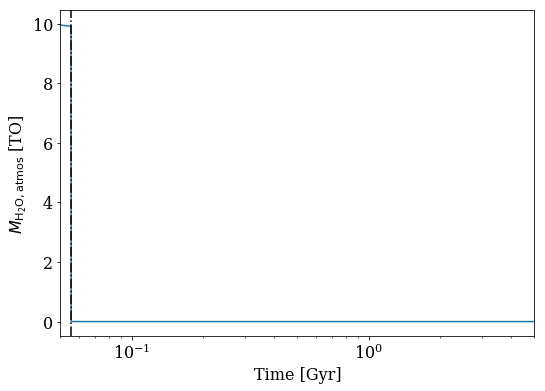

In [33]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()
ax = [fig.add_subplot(1,1,i+1) for i in range(1)]
fig.subplots_adjust(hspace=0)

plt.semilogx(t_array/year/1.0e9, M_H2O_array/1.4e21)
plt.axvline(exit_time/year/1.0e9, color='k', linestyle='-.')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.05, 5.0])
plt.ylabel(r'$M_{{\mathrm{{H_2O, atmos}}}}$ [TO]', fontsize=16)
#plt.savefig('AtmosphereWaterMass_OverTime_2TOtotal_lowerRGTsurf.pdf', bbox_inches='tight')

## Plot simulation results, colour-coded based on surface water regimes.

In [34]:
# Mark where surface becomes desiccated, then where it begins recovering.
tolerance = 1.29e16

dune_first_idx = -1
for ldx in range(0,len(W_s_array)):
    if W_s_array[ldx] <= (0.01*1.4e21):
        dune_first_idx = ldx
        break

desiccated_idx = -1
if dune_first_idx >= 0:
    for idx in range(dune_first_idx+1,len(W_s_array)):
        if W_s_array[idx] <= tolerance:
            desiccated_idx = idx
            break
        
recover_idx = -1
if desiccated_idx >= 0:
    for jdx in range(desiccated_idx+1,len(W_s_array)):
        if W_s_array[jdx] >= tolerance:
            recover_idx = jdx
            break
                     
dune_idx = -1
if recover_idx >= 0:
    for kdx in range(recover_idx+1,len(W_s_array)):
        if W_s_array[kdx] >= (0.01*1.4e21):
            dune_idx = kdx
            break
            
print(desiccated_idx, recover_idx)

-1 -1


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0, 0.5, '$T_{{\\mathrm{{surf}}}}$ [K]')

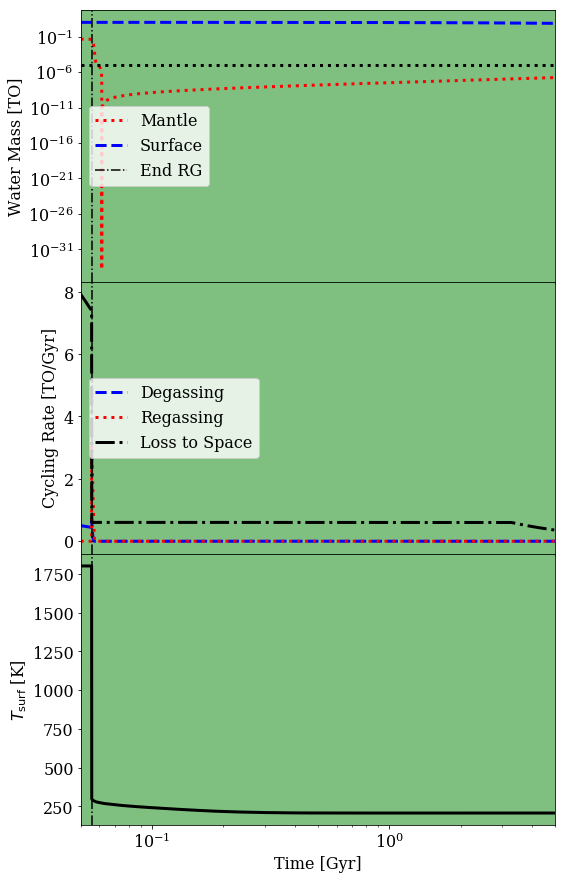

In [35]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,15))
plt.tight_layout()
ax = [fig.add_subplot(3,1,i+1) for i in range(3)]
fig.subplots_adjust(hspace=0)

###### WATER INVENTORY VS. TIME ######
ax1 = plt.subplot(3,1,1)
#plt.loglog(t_array/year/1.0e9, W_m_array/1.4e21, linewidth=3, color='r', linestyle=':', label='Mantle')
#plt.loglog(t_array/year/1.0e9, W_s_array/1.4e21, linewidth=3, color='b', linestyle='--', label='Surface')
plt.loglog(t_array/year/1.0e9, W_m_array/1.4e21, linewidth=3, color='r', linestyle=':', label='Mantle')
plt.loglog(t_array/year/1.0e9, W_s_array/1.4e21, linewidth=3, color='b', linestyle='--', label='Surface')
plt.axhline(y=1.29e16/1.4e21, color='k', linestyle=':',linewidth=3)
plt.axvline(exit_time/year/1.0e9, color='k', linestyle='-.', label='End RG')

# FILL IN REGION WHERE IT IS EARTH-LIKE
plt.axvspan(1.0e-4,t_array[dune_first_idx]/year/1.0e9,alpha=0.5,color='green')
# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array[dune_first_idx]/year/1.0e9, t_array[desiccated_idx]/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array[desiccated_idx]/year/1.0e9, t_array[recover_idx]/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array[recover_idx]/year/1.0e9, t_array[dune_idx]/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.05, 5.0])
plt.ylabel(r'Water Mass [TO]', fontsize=16)
plt.legend(loc='center left', fontsize=16)

####### CYCLING & LOSS RATES VS. TIME #######
ax2 = plt.subplot(3,1,2)
#plt.loglog(t_array/year/1.0e9, degas_array/1.4e21*year*1.0e9, linewidth=3, color='b', linestyle='--', label='Degassing')
#plt.loglog(t_array/year/1.0e9, regas_array/1.4e21*year*1.0e9, linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.loglog(t_array/year/1.0e9, loss_array/1.4e21*year*1.0e9, linewidth=3, color='k', linestyle='-.', label='Loss to Space')
plt.semilogx(t_array/year/1.0e9, degas_array/1.4e21*year*1.0e9, linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array/year/1.0e9, regas_array/1.4e21*year*1.0e9, linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array/year/1.0e9, loss_array/1.4e21*year*1.0e9, linewidth=3, color='k', linestyle='-.', label='Loss to Space')
plt.axvline(exit_time/year/1.0e9, color='k', linestyle='-.')

# FILL IN REGION WHERE IT IS EARTH-LIKE
plt.axvspan(1.0e-4,t_array[dune_first_idx]/year/1.0e9,alpha=0.5,color='green')
# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array[dune_first_idx]/year/1.0e9, t_array[desiccated_idx]/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array[desiccated_idx]/year/1.0e9, t_array[recover_idx]/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array[recover_idx]/year/1.0e9, t_array[dune_idx]/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.05, 5.0])
plt.ylabel(r'Cycling Rate [TO/Gyr]', fontsize=16)
plt.legend(loc='center left', fontsize=16)
#plt.ylim([-0.05,650.])
#plt.legend(bbox_to_anchor=(0.0, 1.0), ncol=2, fontsize=16)

###### SURFACE TEMPERATURE VS. TIME #######
ax3 = plt.subplot(3,1,3)
plt.semilogx(t_array/year/1.0e9, T_surf_array, color='k', linewidth=3)

# FILL IN REGION WHERE IT IS EARTH-LIKE
plt.axvspan(1.0e-4,t_array[dune_first_idx]/year/1.0e9,alpha=0.5,color='green')
# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array[dune_first_idx]/year/1.0e9, t_array[desiccated_idx]/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array[desiccated_idx]/year/1.0e9, t_array[recover_idx]/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array[recover_idx]/year/1.0e9, t_array[dune_idx]/year/1.0e9, alpha=0.5, color='chocolate')

plt.axvline(exit_time/year/1.0e9, color='k', linestyle='-.')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([0.05, 5.0])
plt.ylabel(r'$T_{{\mathrm{{surf}}}}$ [K]', fontsize=16)

#plt.savefig('Cycling_Loss_1DAtmos_2TOtotal_coloured_linearyaxis.pdf', bbox_inches='tight')
#plt.savefig('Cycling_Loss_1DAtmos_1TO_loglog_Psurf_0d01bar.pdf', bbox_inches='tight')
#plt.savefig('Cycling_Loss_1DAtmos_1TO_loglog_Psurf_270bar.pdf', bbox_inches='tight')

In [36]:

print('Planet leaves runaway greenhouse at ', (exit_time+50.0e6*year)/year/1.0e9, ' Gyr')

Planet leaves runaway greenhouse at  0.10562  Gyr
